# Creating a simple Quantum Variational Classifier using Qiskit

In [1]:
# Qiskit dataset imports
from qiskit_machine_learning.datasets import *
from qiskit import QuantumCircuit
# COBYLA is an optimizer that can be used to optimize our parameters without derivatives
# It stands for Constrained Optmization BY Linear Approximation
from qiskit_algorithms.optimizers import COBYLA
# The ZZFeaturemap can easily separate the ad_hoc_data dataset. It is used to encode out input data
# The RealAmplitudes constitutes the variational form of our circuit. This is where the angles of rotation will be
# our parameters
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
import numpy as np
import matplotlib.pyplot as plt
# Statevector is used to directly initialize our qubits as a vector. So we don't have to use a for loop every time we
# want to apply a transformation to them
from qiskit.quantum_info import Statevector
%matplotlib inline

In [2]:
# Training dataset size
training_size = 100

# Test dataset size
test_size = 20

# Dimension of dataset
n = 2 #These are the number of features in the input data

# Construct training and test data
# This function - ad_hoc_data() generates a toy binary classification dataset that can be fully separated with ZZFeatureMap.
# It is built-in to qiskit, and we can customize this dataset however we want. Currently this only works with n=2 or n=3.
# This function shall generate training_size number of positive examples and training_size number of negative examples. So, the total
# number of examples would be 2*training_examples.
training_feature_array, training_label_array, test_feature_array, test_label_array, = \
                            ad_hoc_data(training_size=training_size, test_size=test_size, n =n, gap=0.3,plot_data=False, one_hot=False)
class_labels = ['A','B']

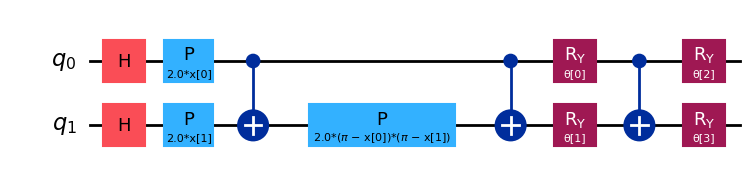

In [3]:
# Initialize our qubits
sv = Statevector.from_label('0'*n)
#We use the ZZFeaturemap to encode our data
feature_map = ZZFeatureMap(n,reps=1)
# And the RealAmplitudes portion to encode our features
var_form = RealAmplitudes(n,reps=1)
circuit = feature_map.compose(var_form)
circuit.decompose().draw('mpl');

In [4]:
def get_data_dict(params,x):
    #This function takes in a list of parameters (params), and a data point.
    #It then creates a dictionary called parameters in which we have the keys as the
    #parameters of the circuit (The Ps and Rys that you can see in the diagram above)
    #and the values as the input data point and the parameter values respectively
    parameters = {}
    for i,p in enumerate(feature_map.ordered_parameters):
        parameters[p] = x[i]
    for i,p in enumerate(var_form.ordered_parameters):
        parameters[p] = params[i]
    return parameters

In [5]:
data = [0.1,0.2]
params = np.array([0.1,1.2,0.02,0.1])
#Testing the above function on random inputs
circ_ = circuit.assign_parameters(get_data_dict(params,data))
circ_.decompose().draw(plot_barriers=True)

┌───┐┌────────┐                       ┌─────────┐     ┌──────────┐
q_0: ┤ H ├┤ P(0.2) ├──■─────────────────■──┤ Ry(0.1) ├──■──┤ Ry(0.02) ├
     ├───┤├────────┤┌─┴─┐┌───────────┐┌─┴─┐├─────────┤┌─┴─┐├─────────┬┘
q_1: ┤ H ├┤ P(0.4) ├┤ X ├┤ P(17.894) ├┤ X ├┤ Ry(1.2) ├┤ X ├┤ Ry(0.1) ├─
     └───┘└────────┘└───┘└───────────┘└───┘└─────────┘└───┘└─────────┘

In [6]:
#This function takes a bit string and class labels. Then it assigns a class label to that bit string.
#to the bit string depending on the hamming weight (sum of 1's in the string) of the bit string.
#If the hamming weight is even (i.e there are even number of 1's), then we assign the class label as 0
#If the hamming weight is odd (i.e there are odd number of 1's), then we assign the class label as 1
def assign_label(bit_string,class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

In [7]:
#The purpose of writing the above function, is that for each data point, when we calculate its output through the
#circuit, we get a dictionary which tells us what is the probability of each of the 4 basis states (00,01,10,11) of the 2 qubits.
#We then assign labels to each basis state based on the parity. We then use the below function to calculate the probabilites
#of the labels that we get from the above function.

#Say we get (1,1,1,0) as the output. Then we can say 1 has a probability of 75% and 0 has a probability of 25%.
def return_probabilities(counts,class_labels):
    #The counts dictionary will have the 4 basis states as the keys, and their counts as the values.
    #We sum the values to get the total number of outputs (i.e. the shots)
    shots = sum(counts.values())
    #Initialize the result dict
    result = {class_labels[0]:0,
             class_labels[1]:0}
    #For every entry in counts, calculate it's label.
    #Then the probability of the entry would be (the value of the entry)/(shots).
    for key, item in counts.items():
        label = assign_label(key,class_labels)
        result[label] += counts[key]/shots
    return result

In [8]:
#Testing out the above function.
return_probabilities({'00':10,'01':10, '11':20},class_labels)

{'A': 0.75, 'B': 0.25}

In [9]:
#We use the above 2 functions to classify the entire dataset.
#For every entry in the input data,we use the same parameter array, and run the input through the circuit
#Then for every circuit, we get the count dictionary and get the probability of every datapoint.
#Which is the y-hat values.
def classify(x_list, params, class_labels):
    qc_list = []
    for x in x_list:
        circ_ = circuit.assign_parameters(get_data_dict(params,x))
        qc = sv.evolve(circ_)
        qc_list += [qc]
    probs = []
    for qc in qc_list:
        counts = qc.probabilities_dict()
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs

In [10]:
x = np.asarray([[0.5,0.5]])
classify(x,params=np.array([0.8,-0.5,1.5,0.5]), class_labels=class_labels)

[{'A': 0.8441066924371945, 'B': 0.1558933075628055}]

In [11]:
#We use the sigmoid function to calculate the cost of predicting the 
#output label based on the current output probability and the actual label
def cost_estimate_sigmoid(probs, expected_label): # probability of label v/s actual labels
    p = probs.get(expected_label)
    sig = None
    if np.isclose(p,0.0):
        sig = 1
    elif np.isclose(p,1.0):
        sig = 0
    else:
        denominator = np.sqrt(2*p*(1-p))
        x = np.sqrt(200)*(0.5-p)/denominator
        sig = 1/(1+np.exp(-x))
    return sig

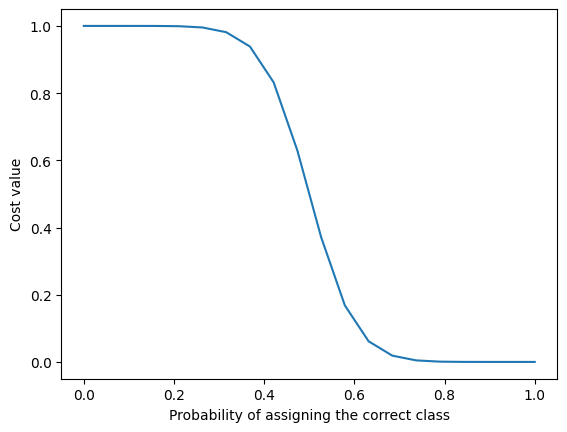

In [12]:
x = np.linspace(0,1,20)
y = [cost_estimate_sigmoid({'A':x_, 'B': 1-x_}, 'A') for x_ in x]
plt.plot(x,y)
plt.xlabel('Probability of assigning the correct class')
plt.ylabel('Cost value')
plt.show()

In [13]:
# This cost function computes the total cost of all the training points, and then divides it by the length of the training data
def cost_function(training_feature_array, training_label_array, class_labels, params, shots=100, print_value=False):
    cost=0
    probs= classify(training_feature_array,params,class_labels)
    for i, prob in enumerate(probs):
        cost+= cost_estimate_sigmoid(prob, 'A' if training_label_array[i]==0 else 'B')
    cost/= len(training_feature_array)
    if print_value:
        print('%.4f'%cost)

    return cost

In [14]:
cost_function(training_feature_array, training_label_array, class_labels,params)

0.6007691467045185

# Train the classifier

In [15]:
# Setup the optimizer
optimizer = COBYLA(maxiter=100)

# Define the objective function for training
objective_function = lambda params: cost_function(training_feature_array, training_label_array, class_labels, params, print_value=True)

# Randomly initialize the parameters
init_params = 2*np.pi*np.random.rand(n*(1)*2)

# train classifier
result = optimizer.minimize(fun=objective_function, x0=init_params)

# Print results
print()
print('opt_params:', result.x)
print('opt_value:', result.fun)

0.4685
0.4686
0.5662
0.3997
0.3278
0.3188
0.3807
0.3187
0.3252
0.2741
0.2572
0.2981
0.2734
0.2772
0.2569
0.2838
0.2726
0.2487
0.2578
0.2594
0.2413
0.2407
0.2429
0.2399
0.2453
0.2408
0.2401
0.2404
0.2395
0.2395
0.2399
0.2390
0.2390
0.2391
0.2390
0.2391
0.2389
0.2388
0.2388
0.2389
0.2387
0.2387
0.2387
0.2389
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387
0.2387

opt_params: [3.71778599 1.83226023 7.2039454  2.2618062 ]
opt_value: 0.23871317818291904


# Testing the trained classifier

In [16]:
results = classify(test_feature_array,params,class_labels)
misclassified = 0
for i, result in enumerate(results):
    assigned_label = np.argmax([p for p in result.values()]) 
    if assigned_label!=test_label_array[i]:
        misclassified+=1
print("Accuracy - ", (misclassified/len(test_label_array))*100, '%')
        

Accuracy -  57.49999999999999 %
